In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error

Load and preprocess

In [ ]:
df = pd.read_csv("/content/Weather_data.csv")
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df["Temperature"] = df["Temperature"].interpolate()

Stationarity test

In [ ]:
result = adfuller(df["Temperature"])
print(f"ADF statistic = {result[0]:.3f}, p-value = {result[1]:.3f}")

ADF statistic = -1.096, p-value = 0.716


Differencing

In [ ]:
df_diff = df["Temperature"].diff().dropna()

ACF and PACF

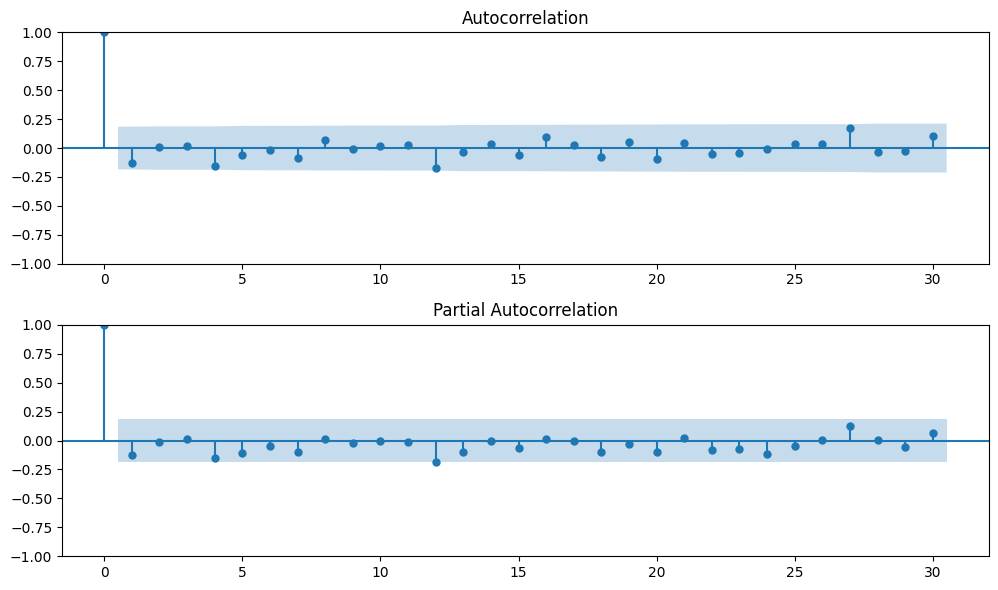

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(df_diff, lags=30, ax=ax[0])
plot_pacf(df_diff, lags=30, ax=ax[1])
plt.tight_layout()
plt.show()

Train/Test split

In [ ]:
n = len(df_diff)
train_end = int(n * 0.8)
train = df_diff.iloc[:train_end]
test = df_diff.iloc[train_end:]

Model fitting

In [ ]:
p = 13
model = AutoReg(train, lags=p, old_names=False)
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Predictions

In [ ]:
pred_train = model_fit.predict(start=train.index[p], end=train.index[-1], dynamic=False)
pred_test = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


Evaluation

In [ ]:
rmse = np.sqrt(mean_squared_error(test, pred_test))
mae = mean_absolute_error(test, pred_test)
print(rmse, mae,sep="\n")

1.3502853217579163
1.064373117847641


Invert forecast to original scale

In [ ]:
last_train_value = df["Temperature"].iloc[train_end]
forecast_orig = pred_test.cumsum() + last_train_value
forecast_orig.index = test.index

Plot results

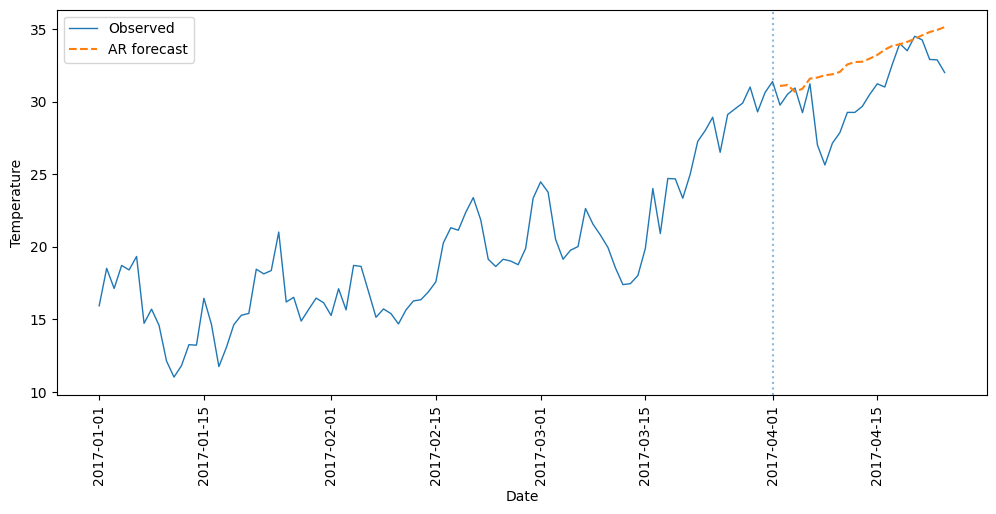

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df["Temperature"], label="Observed", linewidth=1)
plt.plot(forecast_orig, label="AR forecast", linestyle="--")
plt.axvline(df.index[train_end], alpha=0.5, linestyle=":")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.xticks(rotation=90)
plt.legend()
plt.show()